## Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import tensorflow as tf
plt.style.use('ggplot')
import h5py
import math

/home/sb/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from my_utils import *

In [4]:
from tensorflow.python.framework import ops

In [5]:
import scipy
from PIL import Image
from scipy import ndimage

## Load data

In [6]:
# Function to laod data
def load_signs_data():

    # train features and labels
    train_dataset = h5py.File('data/train_signs.h5', "r")
    train_x = np.array(train_dataset["train_set_x"][:]) 
    train_y = np.array(train_dataset["train_set_y"][:]) 

    # test features and labels
    test_dataset = h5py.File('data/test_signs.h5', "r")
    test_x = np.array(test_dataset["test_set_x"][:]) 
    test_y = np.array(test_dataset["test_set_y"][:]) 

    # classes
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    # Increase rank of y to 2
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

train_x, train_y, test_x, test_y, classes = load_signs_data()

In [7]:
# Inspect data
print("train x, y shapes", train_x.shape, train_y.shape)
print("test x, y shapes", test_x.shape, test_y.shape)
print("Classes:", classes)
num_train_examples = train_x.shape[0]
num_test_examples = test_x.shape[0]
num_classes = len(classes)

train x, y shapes (1080, 64, 64, 3) (1, 1080)
test x, y shapes (120, 64, 64, 3) (1, 120)
Classes: [0 1 2 3 4 5]


Data:
Each image - 64x64 pixels and 3 channels
1080 train examples, 120 test examples

label 0


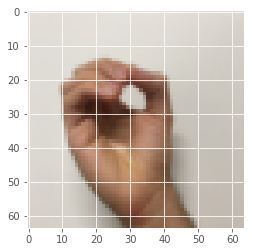

In [8]:
# Visualize images randomly
img_idx = np.random.randint(1080)
plt.imshow(train_x[img_idx])
print("label", train_y[0][img_idx])

## Fully connected deep NN

### Data prep functions

In [9]:
# Convert y to one hot - returns matrix of shape num_classes x num_examples  
def one_hot(y, num_classes):
    # reshape(-1) to convert it to rank 1 
    return np.eye(num_classes)[y.reshape(-1)].T

# Return a list of mini batches of:  
# x_train (shape: num_features x batch_size), y_train (shape: num_classes x batch_size) 
def mini_batches(x_train, y_train, batch_size, seed):
    
    num_examples = x_train.shape[1]  
    num_classes = y_train.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(num_examples))
    shuffled_X = x_train[:, permutation]
    shuffled_Y = y_train[:, permutation].reshape((num_classes,num_examples))

    # General case.
    num_complete_minibatches = math.floor(num_examples/batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * batch_size : (k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[:, k * batch_size : (k + 1) * batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # End case 
    if num_examples % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * batch_size : num_examples]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * batch_size : num_examples]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches   


### Data prep for NN

In [24]:
# Convert images to num_features x num_train_examples and normalize them
train_x_flatten = train_x.reshape(num_train_examples, -1).T 
test_x_flatten = test_x.reshape(num_test_examples, -1).T
train_x_flatten = train_x_flatten / 255
test_x_flatten = test_x_flatten / 255
print("train, test x shapes", train_x_flatten.shape, test_x_flatten.shape )

# Convert y to one hot -  returns matrix of shape num_classes x num_examples 
train_y_onehot = one_hot(train_y, num_classes)
test_y_onehot = one_hot(test_y, num_classes)
print("train, test y flatten shapes", train_y_onehot.shape, test_y_onehot.shape)

train, test x shapes (12288, 1080) (12288, 120)
train, test y flatten shapes (6, 1080) (6, 120)


### Define model and train

In [25]:
# Create placeholders for inputs and outputs
def create_io_placeholders(num_features, num_classes):
    # Input and output
    x = tf.placeholder(tf.float32, shape=[num_features, None], name='X')
    y = tf.placeholder(tf.float32, shape=[num_classes, None], name='Y')
    return x, y

# Initialize parameters for weights and bias of all layers
def initialize_wb_params(scope, num_features, num_classes, nodes_at_layer):
    
    seed = 1
    tf.set_random_seed(seed)
    parameters = {}
    layer = 0
    
    with tf.variable_scope(scope):
        
        num_in = num_features;  num_out = nodes_at_layer[layer] ; layer += 1
        W1 = tf.get_variable("W1", [num_out, num_in], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
        b1 = tf.get_variable("b1", shape=[num_out, 1], initializer = tf.zeros_initializer())
        parameters['W1'] = W1 ; parameters['b1'] = b1
        
        num_in = nodes_at_layer[layer-1];  num_out = nodes_at_layer[layer] ; layer += 1
        W2 = tf.get_variable("W2", [num_out, num_in], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
        b2 = tf.get_variable("b2", shape=[num_out, 1], initializer = tf.zeros_initializer())
        parameters['W2'] = W2 ; parameters['b2'] = b2

        num_in = nodes_at_layer[layer-1];  num_out = num_classes ; layer += 1
        W3 = tf.get_variable("W3", [num_out, num_in], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
        b3 = tf.get_variable("b3", shape=[num_out, 1], initializer = tf.zeros_initializer())
        parameters['W3'] = W3 ; parameters['b3'] = b3
        
        print("W1 = " + str(parameters["W1"]))
        print("b1 = " + str(parameters["b1"]))
        print("W2 = " + str(parameters["W2"]))
        print("b2 = " + str(parameters["b2"]))
        print("W3 = " + str(parameters["W3"]))
        print("b3 = " + str(parameters["b3"]))   
        
    return parameters
    
# Define model forward prop    
def create_model_forward_prop(X, parameters, activation):
    
    W1 = parameters['W1'] ; b1 = parameters['b1']
    W2 = parameters['W2'] ; b2 = parameters['b2']
    W3 = parameters['W3'] ; b3 = parameters['b3']
    
    print("dtypes of W, b:", W1.dtype, b1.dtype, X.dtype)
    
    # Layer 1 - linear + relu
    Z1 = tf.matmul(W1, X) + b1
    A1 = activation(Z1)
    
    # Layer 2 - linear + relu
    Z2 = tf.matmul(W2, A1) + b2
    A2 = activation(Z2)
    
    # Layer 3 - linear ( tf crossentropy takes this as input)
    Z3 = tf.matmul(W3, A2) + b3

    return Z3 

# Define cost function
def cost_fn(Z3, Y_true):    
    # Expects num_examples x num_classes
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y_true)
    cost_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost_val
    
# Create model and train
def create_train_model(x_train, y_train, x_test, y_test, 
                       epochs=1000, batch_size=64, learning_rate=0.001):
    
    # Reset graph
    ops.reset_default_graph()
    seed = 1
    tf.set_random_seed(seed)
    
    # Get sizes of features
    (num_features, num_examples) = x_train.shape
    num_classes = y_train.shape[0]
    
    # Cost for plotting
    train_costs = []
    
    # NN shape
    nodes_at_layer = [25, 12, 6]
    
    # Create placeholders for input X,  output Y. feed_dict later
    X, Y = create_io_placeholders(num_features, num_classes)
    
    # Initialize W, b
    parameters = initialize_wb_params('FCNN', num_features, num_classes, nodes_at_layer)
    
    # Create model forward prop
    Z = create_model_forward_prop(X, parameters, tf.nn.relu)
    
    # Print the model operations
    nn_ops = [op.name for op in tf.get_default_graph().get_operations()] 
    for nn_op in nn_ops: print(nn_op)
    
    # Cost
    cost = cost_fn(Z, Y)
    
    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Train in minibatches
    with tf.Session() as sess:
        
        # initialize W,b
        sess.run(tf.global_variables_initializer())
        
        # train for optimizer, cost
        for epoch in range(epochs):
            train_cost = 0.0
            num_batches = num_examples // batch_size
            batches = mini_batches(x_train, y_train, batch_size, seed)
            for batch in batches:
                (x_batch, y_batch) = batch
                _, batch_cost = sess.run([optimizer, cost], feed_dict = {X: x_batch, Y: y_batch})
                train_cost += batch_cost/num_batches
            if epoch % 3 == 0:
                train_costs.append(train_cost)
            if epoch % 100 == 0:
                print("Cost after epoch %d is %f" % (epoch, train_cost))
        
        # print train and test accuracy, cross-entropy
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train accuracy:", accuracy.eval({X: x_train, Y: y_train}))
        print ("Train cross-entropy:", cost.eval({X: x_train, Y: y_train}))
        print ("Test accuracy:", accuracy.eval({X: x_test, Y: y_test}))
        print ("Test cross-entropy:", cost.eval({X: x_test, Y: y_test}))
    
        # store parameters
        parameters = sess.run(parameters)
    
        # plot cost
        plt.plot(np.squeeze(train_costs))
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
        plt.title("Cost vs Epoch (Learning rate = " + str(learning_rate) + ")")
        plt.show()
        
        return parameters            

W1 = <tf.Variable 'FCNN/W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'FCNN/b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'FCNN/W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'FCNN/b2:0' shape=(12, 1) dtype=float32_ref>
W3 = <tf.Variable 'FCNN/W3:0' shape=(6, 12) dtype=float32_ref>
b3 = <tf.Variable 'FCNN/b3:0' shape=(6, 1) dtype=float32_ref>
dtypes of W, b: <dtype: 'float32_ref'> <dtype: 'float32_ref'> <dtype: 'float32'>
X
Y
FCNN/W1/Initializer/random_uniform/shape
FCNN/W1/Initializer/random_uniform/min
FCNN/W1/Initializer/random_uniform/max
FCNN/W1/Initializer/random_uniform/RandomUniform
FCNN/W1/Initializer/random_uniform/sub
FCNN/W1/Initializer/random_uniform/mul
FCNN/W1/Initializer/random_uniform
FCNN/W1
FCNN/W1/Assign
FCNN/W1/read
FCNN/b1/Initializer/zeros
FCNN/b1
FCNN/b1/Assign
FCNN/b1/read
FCNN/W2/Initializer/random_uniform/shape
FCNN/W2/Initializer/random_uniform/min
FCNN/W2/Initializer/random_uniform/max
FCNN/W2/Initializer/random_uniform/

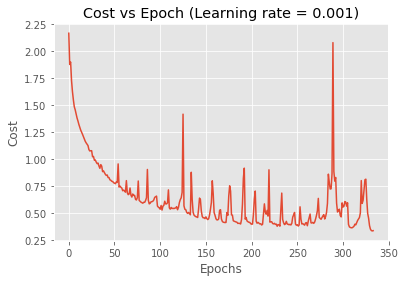

In [26]:
parameters = create_train_model(train_x_flatten, train_y_onehot, test_x_flatten, test_y_onehot)

### Predict

In [27]:
# Function to predict a sign image using trained parameters:
def predict(X, parameters, image_file = None):
    
    imgsize = 12288 ; # 64 x 64 x 3
    
    if image_file is not None:
        image = np.array(ndimage.imread(image_file, flatten=False))
        X = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
        plt.imshow(image)
    
    print(X.shape)
    X = np.array(X).astype(np.float32)
    print(X.shape)
    
    W1 = tf.convert_to_tensor(parameters["W1"], dtype=tf.float32)
    b1 = tf.convert_to_tensor(parameters["b1"], dtype=tf.float32)
    W2 = tf.convert_to_tensor(parameters["W2"], dtype=tf.float32)
    b2 = tf.convert_to_tensor(parameters["b2"], dtype=tf.float32)
    W3 = tf.convert_to_tensor(parameters["W3"], dtype=tf.float32)
    b3 = tf.convert_to_tensor(parameters["b3"], dtype=tf.float32)
    
    params = {"W1": W1,"b1": b1,
              "W2": W2,"b2": b2,
              "W3": W3,"b3": b3}    
    x = tf.placeholder(tf.float32, [imgsize, 1])    
    Z = create_model_forward_prop(X, parameters, tf.nn.relu)
    ypred = tf.argmax(Z)
    
    with tf.Session() as sess:
        prediction = sess.run(ypred, feed_dict = {x: X})
        
    return prediction

(12288, 1)
(12288, 1)
dtypes of W, b: float32 float32 float32
Predicted label is 4


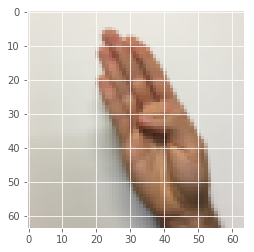

In [29]:
# Predict test image
image = test_x_flatten[:,np.random.randint(120)]
plt.imshow(np.squeeze(image.reshape(64,64,3,1)))
pred = predict(image[:,np.newaxis], parameters)
print("Predicted label is", pred[0])

(12288, 1)
(12288, 1)
dtypes of W, b: float32 float32 float32
Predicted label is 3


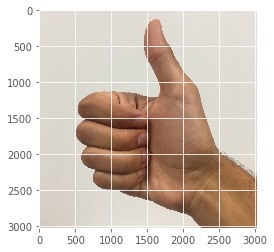

In [30]:
# Predict new image (out of train data distribution)
pred = predict(None, parameters, 'data/thumbs_up.jpg',)
print("Predicted label is", pred[0])

## Convolutional NN

### Data prep functions

In [16]:
# Convert y to one hot - returns matrix of shape num_classes x num_examples  
def one_hot(y, num_classes):
    # reshape(-1) to convert it to rank 1 
    return np.eye(num_classes)[y.reshape(-1)].T

# Return a list of mini batches of:  
# x_train (shape: batch_size x h x w x c), y_train (shape: batch_size x num_classes) 
def mini_batches_cnn(x_train, y_train, batch_size, seed):
    
    num_examples = x_train.shape[0]  
    num_classes = y_train.shape[1]
    mini_batches = []
    np.random.seed(seed)
    
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(num_examples))
    shuffled_X = x_train[permutation,:,:,:]
    shuffled_Y = y_train[permutation,:]

    # General case
    num_complete_minibatches = math.floor(num_examples/batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * batch_size : (k + 1) * batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * batch_size : (k + 1) * batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # End case 
    if num_examples % batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * batch_size : num_examples, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * batch_size : num_examples, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches    

### Data prep for CNN

In [17]:
# Normalize image pixels. No need to flatten like in fully connected NN
train_x_cnn = train_x / 255
test_x_cnn = test_x / 255
print("train, test x shapes", train_x_cnn.shape, test_x_cnn.shape )

# Convert y to one hot -  returns matrix of shape num_classes x num_examples 
train_y_onehot = one_hot(train_y, num_classes).T
test_y_onehot = one_hot(test_y, num_classes).T
print("train, test y flatten shapes", train_y_onehot.shape, test_y_onehot.shape)

train, test x shapes (1080, 64, 64, 3) (120, 64, 64, 3)
train, test y flatten shapes (1080, 6) (120, 6)


### Define model and train

In [18]:
# Create placeholders for inputs and outputs
def create_io_placeholders(img_h, img_w, num_channels, num_classes):
    # Input and output
    x = tf.placeholder(tf.float32, shape=[None, img_h, img_w, num_channels], name='X')
    y = tf.placeholder(tf.float32, shape=[None, num_classes], name='Y')
    return x, y

# Initialize parameters for weights of all layers
def initialize_wb_params(scope, num_channels, num_classes, ksize_at_layer, channels_at_layer):
    
    seed = 1
    tf.set_random_seed(seed)
    parameters = {}
    layer = 0
    
    with tf.variable_scope(scope):
        
        num_in = num_channels;  num_out = channels_at_layer[layer] ; ksize = ksize_at_layer[layer] ; layer += 1
        W1 = tf.get_variable("W1", [ksize, ksize, num_in, num_out], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
        #b1 = tf.get_variable("b1", shape=[num_out], initializer = tf.zeros_initializer())
        parameters['W1'] = W1 ; #parameters['b1'] = b1
        
        num_in = channels_at_layer[layer-1];  num_out = channels_at_layer[layer] ; ksize = ksize_at_layer[layer] ; layer += 1
        W2 = tf.get_variable("W2", [ksize, ksize, num_in, num_out], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
        #b2 = tf.get_variable("b2", shape=[num_out], initializer = tf.zeros_initializer())
        parameters['W2'] = W2 ; #parameters['b2'] = b2
     
        print("W1 = " + str(parameters["W1"]))
        #print("b1 = " + str(parameters["b1"]))
        print("W2 = " + str(parameters["W2"]))
        #print("b2 = " + str(parameters["b2"]))
        
    return parameters
    
# Define model forward prop    
def create_model_forward_prop(X, parameters, num_classes, activation):
    
    W1 = parameters['W1'] ; #b1 = parameters['b1']
    W2 = parameters['W2'] ; #b2 = parameters['b2']
       
    # Layer 1 - conv2d + relu + maxpool
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = activation(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    # Layer 2 - conv2d + relu + maxpool
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = activation(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')

    # Flatten + Fully connected layer
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)    
    
    return Z3 

# Define cost function
def cost_fn(Z3, Y_true):    
    # Expects num_examples x num_classes
    logits = Z3
    labels = Y_true
    cost_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost_val
    
# Create model and train
def create_train_cnn_model(x_train, y_train, x_test, y_test, 
                       epochs=1000, batch_size=64, learning_rate=0.001):
    
    # Reset graph
    ops.reset_default_graph()
    seed = 1
    tf.set_random_seed(seed)
    
    # Get sizes of features
    (num_examples, img_h, img_w, num_channels) = x_train.shape
    num_classes = y_train.shape[1]
    
    # Cost for plotting
    train_costs = []
    
    # CNN kernel sizes and channel sizes
    ksize_at_layer = [4,2]
    channels_at_layer = [8,16]    
    
    # Create placeholders for input X,  output Y. feed_dict later
    X, Y = create_io_placeholders(img_h, img_w, num_channels, num_classes)
    
    # Initialize W, b
    parameters = initialize_wb_params('CNN', num_channels, num_classes, ksize_at_layer, channels_at_layer)
    
    # Create model forward prop
    Z = create_model_forward_prop(X, parameters, num_classes, tf.nn.relu)
    
    # Print the model operations
    nn_ops = [op.name for op in tf.get_default_graph().get_operations()] 
    for nn_op in nn_ops: print(nn_op)
    
    # Cost
    cost = cost_fn(Z, Y)
    
    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Train in minibatches
    with tf.Session() as sess:
        
        # initialize W,b
        sess.run(tf.global_variables_initializer())
        
        # train for optimizer, cost
        for epoch in range(epochs):
            train_cost = 0.0
            num_batches = num_examples // batch_size
            batches = mini_batches_cnn(x_train, y_train, batch_size, seed)
            for batch in batches:
                (x_batch, y_batch) = batch
                _, batch_cost = sess.run([optimizer, cost], feed_dict = {X: x_batch, Y: y_batch})
                train_cost += batch_cost/num_batches
            if epoch % 3 == 0:
                train_costs.append(train_cost)
            if epoch % 100 == 0:
                print("Cost after epoch %d is %f" % (epoch, train_cost))
        
        # print train and test accuracy, cross-entropy
        correct_prediction = tf.equal(tf.argmax(Z,1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train accuracy:", accuracy.eval({X: x_train, Y: y_train}))
        print ("Train cross-entropy:", cost.eval({X: x_train, Y: y_train}))
        print ("Test accuracy:", accuracy.eval({X: x_test, Y: y_test}))
        print ("Test cross-entropy:", cost.eval({X: x_test, Y: y_test}))
    
        # Save model variables
        saver = tf.train.Saver()
    
        # store parameters
        parameters = sess.run(parameters)
    
        # plot cost
        plt.plot(np.squeeze(train_costs))
        plt.xlabel('Epochs')
        plt.ylabel('Cost')
        plt.title("Cost vs Epoch (Learning rate = " + str(learning_rate) + ")")
        plt.show()
        
        # Save graph and model
        save_path = saver.save(sess, "./model/sign_classifer")
        print("Model saved in ", save_path)
        
        return parameters 

W1 = <tf.Variable 'CNN/W1:0' shape=(4, 4, 3, 8) dtype=float32_ref>
W2 = <tf.Variable 'CNN/W2:0' shape=(2, 2, 8, 16) dtype=float32_ref>
X
Y
CNN/W1/Initializer/random_uniform/shape
CNN/W1/Initializer/random_uniform/min
CNN/W1/Initializer/random_uniform/max
CNN/W1/Initializer/random_uniform/RandomUniform
CNN/W1/Initializer/random_uniform/sub
CNN/W1/Initializer/random_uniform/mul
CNN/W1/Initializer/random_uniform
CNN/W1
CNN/W1/Assign
CNN/W1/read
CNN/W2/Initializer/random_uniform/shape
CNN/W2/Initializer/random_uniform/min
CNN/W2/Initializer/random_uniform/max
CNN/W2/Initializer/random_uniform/RandomUniform
CNN/W2/Initializer/random_uniform/sub
CNN/W2/Initializer/random_uniform/mul
CNN/W2/Initializer/random_uniform
CNN/W2
CNN/W2/Assign
CNN/W2/read
Conv2D
Relu
MaxPool
Conv2D_1
Relu_1
MaxPool_1
Flatten/flatten/Shape
Flatten/flatten/strided_slice/stack
Flatten/flatten/strided_slice/stack_1
Flatten/flatten/strided_slice/stack_2
Flatten/flatten/strided_slice
Flatten/flatten/Reshape/shape/1
Flatt

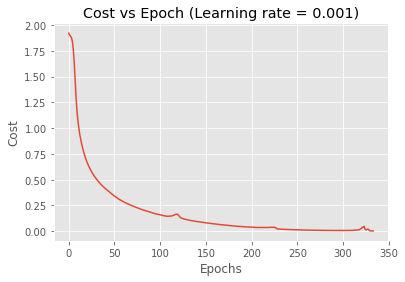

Model saved in  ./model/sign_classifer


In [19]:
parameters = create_train_cnn_model(train_x_cnn, train_y_onehot, test_x_cnn, test_y_onehot)

### Predict

In [20]:
# Function to predict a sign image using trained parameters:
def predict(image_x, parameters, image_file = None):
    
    img_h = 64; img_w = 64; num_channels = 3
    num_classes = 6
    
    if image_file is not None:
        image = np.array(ndimage.imread(image_file, flatten=False))
        image_x = scipy.misc.imresize(image, size=(64,64))
        image_x = image_x[np.newaxis,:]
        plt.imshow(image)    
     
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('./model/sign_classifer.meta')
        saver.restore(sess,tf.train.latest_checkpoint('./model/'))
        op = tf.get_default_graph().get_tensor_by_name("fully_connected/BiasAdd:0")
        X = tf.get_default_graph().get_tensor_by_name("X:0")
        print(op, X)

        y_pred = sess.run(op, feed_dict = {X: image_x})
        prediction = sess.run(tf.argmax(y_pred, 1))      
        #print("Predicted label is", y_pred_class[0])
    
    return prediction

INFO:tensorflow:Restoring parameters from ./model/sign_classifer
Tensor("fully_connected/BiasAdd:0", shape=(?, 6), dtype=float32) Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Predicted label is 0


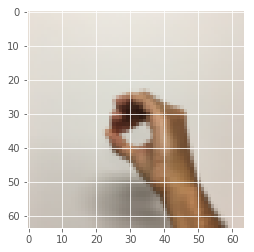

In [21]:
# Predict test image
image = test_x_cnn[np.random.randint(120),:,:,:]
plt.imshow(np.squeeze(image.reshape(1,64,64,3)))
pred = predict(image[np.newaxis,:], parameters)
print("Predicted label is", pred[0])

INFO:tensorflow:Restoring parameters from ./model/sign_classifer
Tensor("fully_connected/BiasAdd:0", shape=(?, 6), dtype=float32) Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Predicted label is 3


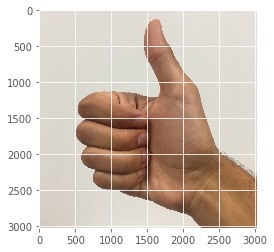

In [22]:
# Predict new image (out of train data distribution)
pred = predict(None, parameters, 'data/thumbs_up.jpg',)
print("Predicted label is", pred[0])

## Summary

Fully connected and Conv nets have been built using tensorflow.
Test accuracy of fully connected NN is 68.3% 
Test accuracy of CNN is 87.5%